# PCA

In [1]:
# imports
import os
import numpy as np
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

%matplotlib inline

## PCA of HalfCheetah-v3 state space

Helper routines

In [17]:
def load_state_data(path):
    save_dict = pickle.load(open(path, "rb"))
    state_visit = save_dict["transitions"]
    return state_visit

def process_state_data(state_data):
    """
    :param state_data: dict mapping state to frequency.
    state is stored as raw bytes
    :returns: A matrix of all the unique states in state_data
    stacked vertically as a numpy array ( num_states x state_dim )
    """
    state_visit = state_data
    state_data = list(state_data.keys())
    state_data = [np.frombuffer(state, dtype=np.float32) for state in state_data]
    state_matrix = np.stack( state_data )
    return state_matrix, state_visit
    
def plot_pca_variance(state_matrix):
    """
    :param state_matrix: processed state data
    :outputs a plot of the cumulative explained variance
    vs number of components
    """
    pca = PCA().fit(state_matrix)
    sns.set(style="darkgrid", font_scale=1.0)
    
    # plot cumulative explained variance
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(np.cumsum(pca.explained_variance_ratio_))
    ax.set_xlabel('number of components')
    ax.set_ylabel('cumulative explained variance')
    ax.set_title('Cumulative Explained Variance vs. Number of Components')
    plt.show()
    
def plot_pca_projection(state_matrix, class_labels):
    """
    :param state_matrix: processed state data
    :param class_labels: class label for each state in state_matrix
    :outputs a plot of the distribution of states along first two PCA
    components
    """
    # plot distribution of states on 2-D manifold
    pca = PCA(2).fit(state_matrix)
    projected = pca.fit_transform(state_matrix)
    np.save( 'results1/TD3_HalfCheetah-v3_seed1_pca.npy', projected )
    print(state_matrix.shape)
    print(projected.shape)
    class_labels = np.array(class_labels, dtype=int)
    num_classes = 3
    fig, axs = plt.subplots(1, num_classes, 
                            sharex=True, sharey=True,
                            figsize=(10,5))
    colors = ['red', 'green', 'blue']
    for class_id in range(num_classes):
        ax = axs[class_id]
        cls_projected = projected[class_labels==class_id]
        ax.plot(cls_projected[::100, 0], cls_projected[::100, 1],
                marker='o', markeredgewidth=0,
                markerfacecolor=colors[class_id], linestyle='')
        ax.set_xlabel('component 1')
        ax.set_ylabel('component 2')
        class_name = get_classname_from_id(class_id)
        ax.set_title(f'{class_name} states ')
    plt.show()
    
def plot_pca_projection_3d(state_matrix, class_labels):
    """
    :param state_matrix: processed state data
    :param class_labels: class label for each state in state_matrix
    :outputs a plot of the distribution of states along first two PCA
    components
    """
    # plot distribution of states on 2-D manifold
    pca = PCA(3).fit(state_matrix)
    projected = pca.fit_transform(state_matrix)
    np.save( 'results1/TD3_HalfCheetah-v3_seed1_pca.npy', projected )
    print(state_matrix.shape)
    print(projected.shape)
    #import pdb; pdb.set_trace()
    class_labels = np.array(class_labels, dtype=int)
    # fig, ax = plt.subplots(1, figsize=(10,5), projection='3d')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    sc_plot = ax.scatter(projected[::100, 0],
       projected[::100, 1], projected[::100, 2],
       c=class_labels[::100], edgecolor='none', alpha=0.5,
       cmap=plt.cm.get_cmap('Spectral', 3)
    )
    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.set_zlabel('component 3')
    ax.set_title('Distribution of states according to first 3 principal components')
    plt.colorbar(sc_plot);
    plt.show()

def mean_std_state_visit(state_visit):
    """
    :returns: mean and std of visit frequencies
    """
    mean = np.mean(state_visit.values())
    std = np.std(state_visit.values())
    return mean, std

def get_class_label(num_visits, cutoff_low, cutoff_high):
    if num_visits <= cutoff_low:
        # low frequency state
        return 0
    elif num_visits > cutoff_low and num_visits <= cutoff_high:
        # medium frequency state
        return 1
    else:
        # high frequency state
        return 2
    
def get_classname_from_id(class_id):
    if class_id == 0:
        return 'low-frequency'
    elif class_id == 1:
        return 'medium-frequency'
    elif class_id == 2:
        return 'high-frequency'
    else:
        raise Exception(f'Unrecognized class id: {class_id}')

def get_state_class_labels(state_visit):
    """
    :param state_visit: dict maping states to visit frequency
    :returns: class label for each state
    """
    visit_freq = list( state_visit.values() )
    visit_freq.sort()
    N = len(visit_freq)
    cutoff_low, cutoff_high = visit_freq[N//10], visit_freq[9*N//10]
    print(f'cutoff_low: {cutoff_low} cutoff_high: {cutoff_high}')
    class_labels = []
    for _, num_visits in state_visit.items():
        class_labels.append( 
            get_class_label(num_visits, cutoff_low, cutoff_high) )
    print(f'len class labels: {len(class_labels)}')
    return class_labels
    
    
def run_pca(path):
    state_data = load_state_data(path)
    state_matrix, state_visit = process_state_data(state_data)
    class_labels = get_state_class_labels(state_visit)
    plot_pca_variance(state_matrix)
    plot_pca_projection(state_matrix, class_labels)
    plot_pca_projection_3d(state_matrix, class_labels)
    

Run PCA for seed1

cutoff_low: 28 cutoff_high: 591
len class labels: 996086


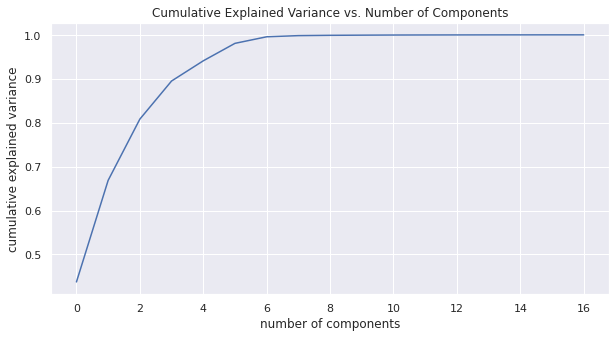

(996086, 17)
(996086, 2)


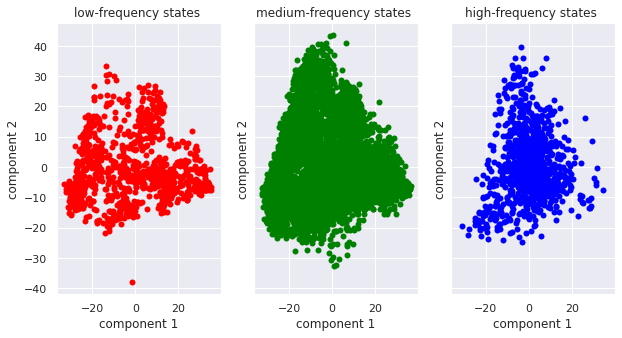

(996086, 17)
(996086, 3)


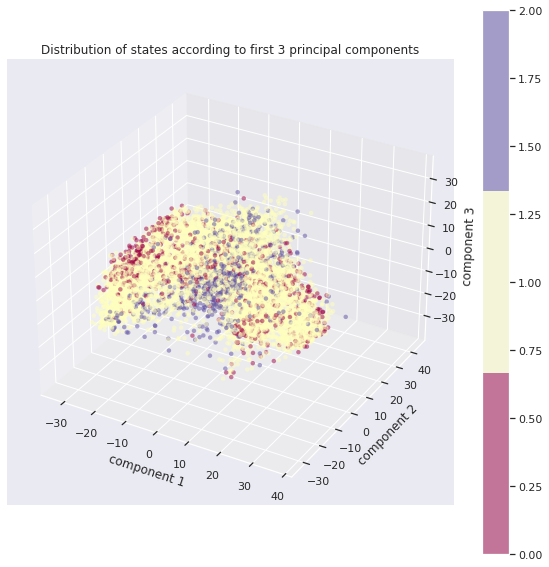

In [18]:
state_path = "results1/TD3_HalfCheetah-v3_seed1_batch0_trans.pkl"
run_pca(state_path)

# The End